## Overview
The U.S. energy landscape has transformed dramatically since 1949. Fossil fuels once dominated the mix, but nuclear and renewable sources have gradually expanded. Using data from the U.S. Energy Information Administration, this analysis compares production trends across major energy sources to show how the national energy portfolio has evolved over 75 years. Through multiple visualizations, we examine shifts in magnitude, growth rates, and relative contributions to total energy output.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+notebook_connected'

In [10]:
EIA = "EIA Primary Energy Overview.csv"
df = pd.read_csv(EIA)

#df.columns

In [11]:
# I am gonna clean and organize the data a little better
df['Year'] = (df['YYYYMM'] // 100).astype(int)
df['MM'] = (df['YYYYMM'] % 100).astype(int)
annual = df[df['MM'] == 13].copy()

#df.columns

# put it in descending order so its more organized
desc_order = [
    "Total Fossil Fuels Production",
    "Nuclear Electric Power Production",
    "Total Renewable Energy Production",
    "Total Primary Energy Production",
    "Total Fossil Fuels Consumption",
    "Nuclear Electric Power Consumption",
    "Total Renewable Energy Consumption",
    "Total Primary Energy Consumption"
]

new_chart = annual[annual['Description'].isin(desc_order)].copy()

# tidy the data to make it more convenient 
new_chart['Type'] = new_chart['Description'].apply(
    lambda x: "Production" if "Production" in x else "Consumption"
)
new_chart['Category'] = (
    new_chart['Description']
    .str.replace("Total ", "")
    .str.replace("Electric Power ", "")
    .str.replace("Production", "")
    .str.replace("Consumption", "")
    .str.strip()
)
tidy = new_chart[['Year', 'Category', 'Type', 'Value']].copy()

prod = tidy[tidy['Type'] == 'Production'].pivot_table(index='Year', columns='Category', values='Value')
cons = tidy[tidy['Type'] == 'Consumption'].pivot_table(index='Year', columns='Category', values='Value')

# I asked chat how to add a source line under each chart at the beginning so I don't have to keep adding a new one each time
def add_source(text="Source: U.S. Energy Information Administration (EIA), Monthly Energy Review Table 1.1"):
    plt.figtext(0.5, -0.04, text, ha="center", fontsize=9, style="italic")

#tidy.head

### Snapshot of 2024 Energy Production
This dot plot compares 2024 U.S. energy production across fossil fuels, nuclear, renewables, and total primary energy. Fossil fuels continue to dominate, though renewables now represent a growing share of the national energy mix.

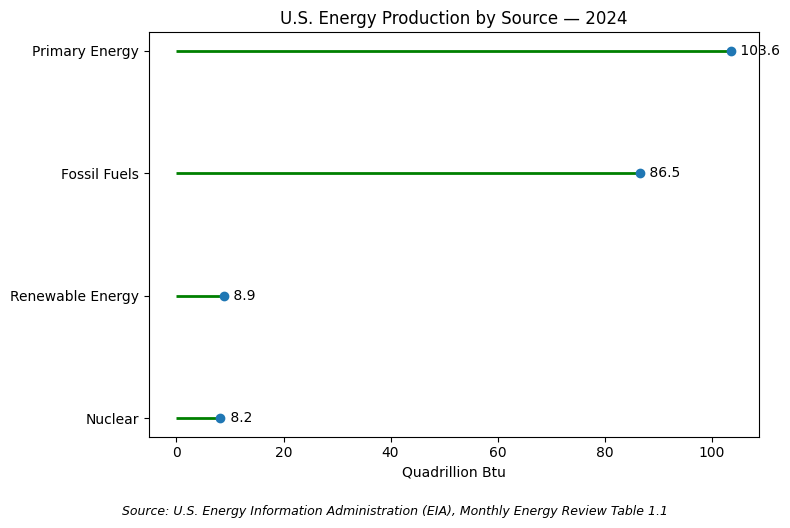

In [271]:
year_dot = 2024 if 2024 in prod.index else int(prod.index.max())
dot_series = prod.loc[year_dot, ['Fossil Fuels','Nuclear','Renewable Energy','Primary Energy']].dropna()
dot_sorted = dot_series.sort_values(ascending=True)

plt.figure(figsize=(8,5))
ypos = np.arange(len(dot_sorted))
plt.hlines(y=ypos, xmin=0, xmax=dot_sorted.values, color='green', linewidth=2)
plt.plot(dot_sorted.values, ypos, 'o')
plt.yticks(ypos, dot_sorted.index)
plt.xlabel("Quadrillion Btu")
plt.title(f"U.S. Energy Production by Source — {year_dot}")
for i, (name, val) in enumerate(dot_sorted.items()):
    plt.text(val + 1, i, f" {val:.1f}", va='center')
add_source()
plt.tight_layout()
plt.show()

### From 1949 to 2024: Changing Energy Mix
To capture long-run change, the slope chart compares total production levels in 1949 and 2024. The steep rise in renewables and nuclear shows diversification, while fossil fuels, though still leading, show slower relative growth. Direct labeling of start and end values keeps focus on trend direction rather than precise magnitudes.

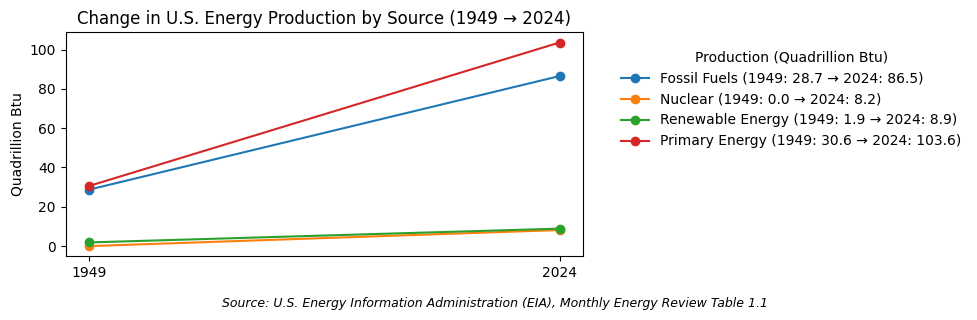

In [275]:
earliest = int(prod.index.min())
latest = int(prod.index.max())
plt.figure(figsize=(10,3))
for green in ['Fossil Fuels','Nuclear','Renewable Energy','Primary Energy']:
    if green in prod.columns:
        y0, y1 = prod.loc[earliest, green], prod.loc[latest, green],
        plt.plot([0, 1], [y0, y1], marker='o',
                 label=f"{green} ({earliest}: {y0:.1f} → {latest}: {y1:.1f})")

plt.xticks([0,1],[earliest,latest])
plt.ylabel("Quadrillion Btu")
plt.title(f"Change in U.S. Energy Production by Source ({earliest} → {latest})")
plt.legend(
    title="Production (Quadrillion Btu)",
    frameon=False,
    bbox_to_anchor=(1.05, .7),
    loc="center left"
)
add_source()
plt.tight_layout()
plt.show()

### Energy Production Over Time (1949–2024)
The line chart shows continuous changes in energy production across major sources. Fossil fuels remain dominant, but renewables exhibit strong growth beginning in the early 2000s, while nuclear levels off after 1990.

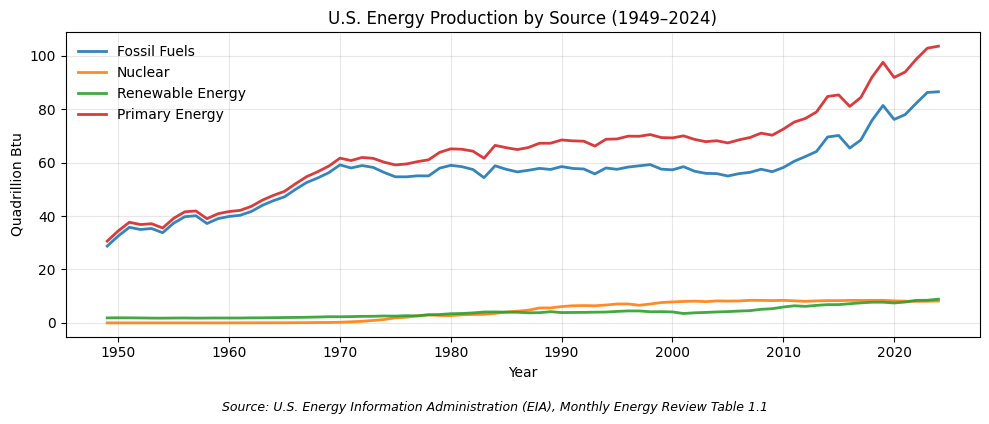

In [57]:
plt.figure(figsize=(10,4))
for t in ['Fossil Fuels', 'Nuclear', 'Renewable Energy', 'Primary Energy']:
    if t in prod.columns:
        s = prod[t].dropna()
        plt.plot(s.index, s.values, linewidth=2, alpha=0.9, label=t)

plt.xlabel("Year")
plt.ylabel("Quadrillion Btu")
plt.title("U.S. Energy Production by Source (1949–2024)")
plt.legend(frameon=False, loc='upper left')
plt.grid(alpha=0.3)
add_source()
plt.tight_layout()
plt.show()

### U.S. Energy Consumption by Source (1949–2024)
Each panel shows the trend in U.S. energy consumption for fossil fuels, nuclear, and renewable energy using a shared y-axis. Fossil fuels remain dominant and consistently exceed 70 quadrillion Btu, while nuclear and renewables stay within the range of about 5 to 10 quadrillion Btu. The shared scale emphasizes the large gap between sources even as renewables show steady growth after 2000 and nuclear levels off around the early 1990s.

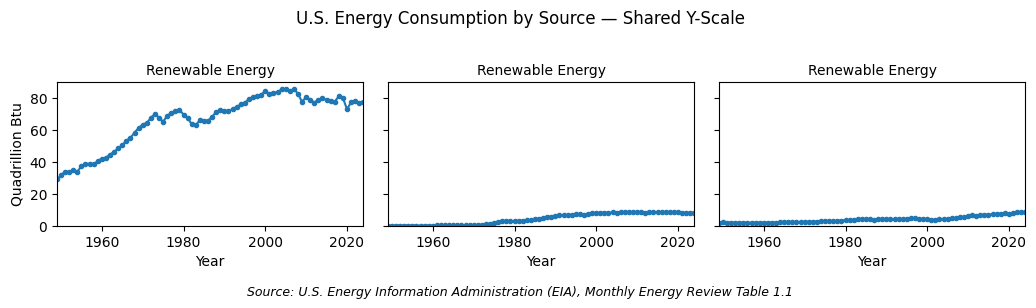

In [281]:
import math

energy = [e for e in ['Fossil Fuels','Nuclear','Renewable Energy'] if e in cons.columns]
n = len(energy)
cols = 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(3.5*cols, 2.8*rows), sharex=True, sharey=True)
axes = axes.flatten()

ymin = 0
ymax = cons[energy].max().max() * 1.05
xmin, xmax = int(cons.index.min()), int(cons.index.max())

for i, en in enumerate(subcats):
    ax = axes[i]
    s = cons[en].dropna()
    ax.plot(s.index, s.values, marker='o', markersize=3)
    ax.set_title(cat, fontsize=10)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if i % cols == 0:
        ax.set_ylabel("Quadrillion Btu")
    if i >= n - cols:
        ax.set_xlabel("Year")

# hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("U.S. Energy Consumption by Source — Shared Y-Scale", y=0.98, fontsize=12)
fig.tight_layout(rect=[0,0,1,0.96])
add_source()
plt.show()


### Normalized U.S. Energy Consumption (Indexed to 2000 = 100)
The chart tracks changes in U.S. energy consumption from 1994 to 2024, with all sources indexed to their 2000 levels (2000 = 100). By 2024, renewable energy reached an index value of about 212, indicating consumption increased by roughly 112% since 2000. Fossil fuels rose slightly to 104, a 4% increase, while nuclear energy declined to around 92, an 8% decrease relative to 2000. Although the series begins in 1994, the normalization highlights how each energy source has shifted proportionally over the past two decades, emphasizing the strong growth of renewables compared to the stability of fossil fuels and the modest decline of nuclear energy.

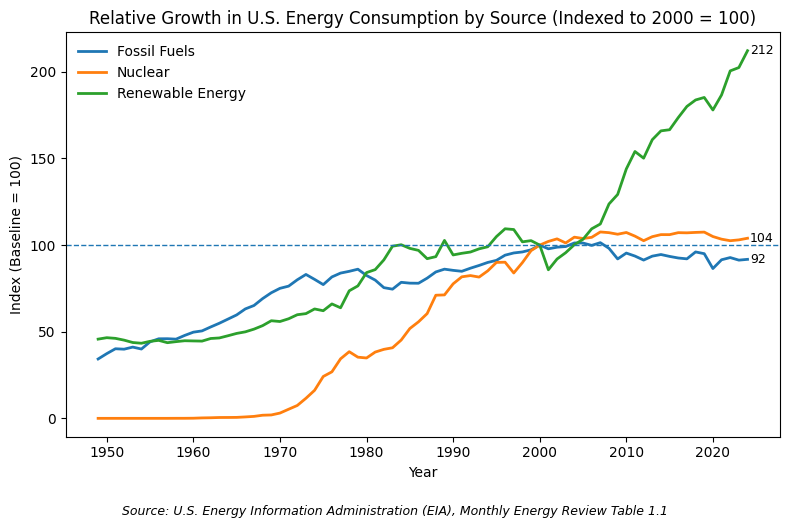

In [284]:
baseline = 2000 if 2000 in cons.index else int(cons.index.min())
norm_cols = [c for c in ['Fossil Fuels','Nuclear','Renewable Energy'] if c in cons.columns]
norm = cons[norm_cols].copy()

for c in norm_cols:
    base = norm.loc[baseline, c]
    norm[c] = (norm[c] / base * 100) if (pd.notna(base) and base != 0) else np.nan

plt.figure(figsize=(8,5))
for c in norm_cols:
    plt.plot(norm.index, norm[c], linewidth=2, label=c)
    plt.text(norm.index[-1]+0.3, norm[c].iloc[-1], f"{norm[c].iloc[-1]:.0f}", va='center', fontsize=9)

plt.axhline(100, linestyle='--', linewidth=1)
plt.xlabel("Year")
plt.ylabel("Index (Baseline = 100)")
plt.title(f"Relative Growth in U.S. Energy Consumption by Source (Indexed to {baseline} = 100)")
plt.legend(frameon=False, loc='upper left')
add_source()
plt.tight_layout()
plt.show()


### Normalized U.S. Energy Production and Consumption (Indexed to 2000 = 100)
This chart compares the relative growth of U.S. energy production and consumption from 1994 to 2024, indexed to their 2000 levels. Renewables show the largest proportional increase, with both production and consumption rising by just over 110%. Fossil fuels remain steady, growing by about 5%, while nuclear energy declines slightly. The side-by-side view highlights how supply and demand have shifted together, showing that renewable energy expansion has been consistent across both production and consumption.

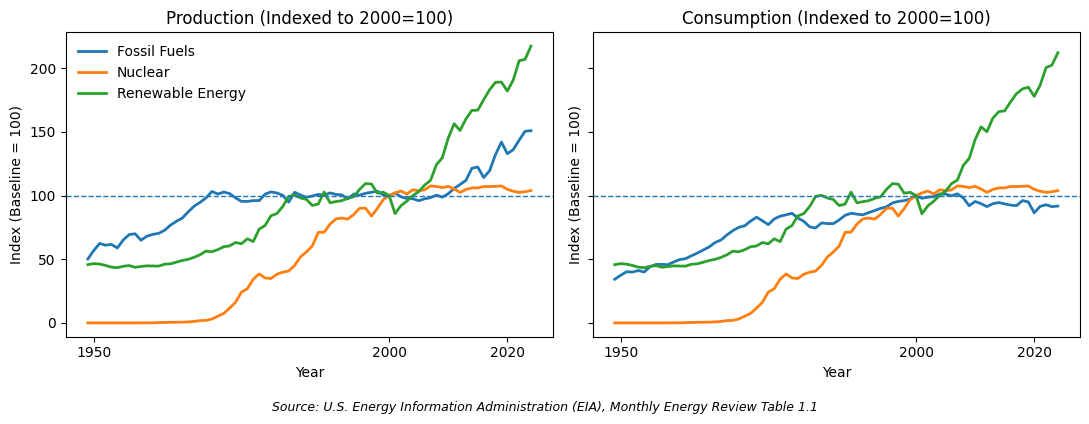

In [288]:
# Normalized production compared to consumption
baseline = 2000 if 2000 in prod.index else int(prod.index.min())
cols = [c for c in ['Fossil Fuels','Nuclear','Renewable Energy'] if c in prod.columns and c in cons.columns]

norm_prod = prod[cols].copy()
norm_cons = cons[cols].copy()

for c in cols:
    bp = norm_prod.loc[baseline, c]
    bc = norm_cons.loc[baseline, c]
    norm_prod[c] = (norm_prod[c] / bp * 100) if (pd.notna(bp) and bp != 0) else float('nan')
    norm_cons[c] = (norm_cons[c] / bc * 100) if (pd.notna(bc) and bc != 0) else float('nan')

fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=True)
for c in cols:
    axes[0].plot(norm_prod.index, norm_prod[c], linewidth=2, label=c)
    axes[1].plot(norm_cons.index, norm_cons[c], linewidth=2, label=c)

for ax, title in zip(axes, [f"Production (Indexed to {baseline}=100)", f"Consumption (Indexed to {baseline}=100)"]):
    ax.axhline(100, linestyle='--', linewidth=1)
    ax.set_xlabel("Year"); ax.set_ylabel("Index (Baseline = 100)")
    ax.set_title(title)
    # light, minimal ticks
    years = [1950, 2000, 2020] if norm_prod.index.min() <= 1950 else [baseline, 2020]
    ax.set_xticks([y for y in years if y >= norm_prod.index.min() and y <= norm_prod.index.max()])

axes[0].legend(frameon=False, loc='upper left')
fig.tight_layout()
add_source()
plt.show()

## Final Reflection

This project examines how the U.S. energy mix has evolved from 1949 to 2024 through five comparative visualizations of production and consumption. The dot plot offered a snapshot of 2024 energy production, showing that fossil fuels remain the largest source while renewables have become a significant contributor. The slope chart captured long-term change between 1949 and 2024, emphasizing the steady rise of renewables and nuclear energy relative to fossil fuels. The line chart extended this perspective, displaying the continuous trajectory of each source over time and reinforcing the dominance of fossil fuels alongside gradual renewable growth. The small-multiples chart presented each consumption category on a shared y-axis, enabling direct comparison of scale and highlighting that renewables increased notably after 2000, while nuclear energy leveled off. Finally, the normalized index chart provided a proportional comparison since 2000, showing renewables more than doubling in consumption while fossil fuels and nuclear energy remained relatively stable.

Among these visualizations, the normalized index chart best supports the comparison question because it reveals relative growth rather than absolute magnitude. While the line and small-multiples charts emphasize continuity and scale, the normalized view makes clear how renewables have expanded at a much faster rate. Collectively, these designs show that the U.S. energy system continues to rely heavily on fossil fuels but is gradually diversifying, with renewables driving the most substantial proportional change in the national energy mix.